# Assignment 3 - Network biology 

In [41]:
# Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [42]:
# Helper class to build and simulate boolean network from the practical

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)

## Regulatory network for Mutation A
We use the modified rule provided in the assignment instructions on the code provided in the practical to create the regulatory network for Mutation A

In [44]:
# Create the regulatory network (taken from the practical but modified for mutation A)
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)") # Modified rule for Mutation A: p53 Knockout (Loss of tumor suppressor)
network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = BROKEN (always OFF)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


# Scenario Analysis
We start first with the scenario analysis for mutation A

In [46]:
# Healthy cell, Stressed Cell and Oncogene Hijacked Cell scenarios
# The code is once again taken from the practical!

scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

results = {}

# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run Stressed Cell scenario
m = "Stressed Cell"
initial_state = scenarios[m]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[m] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {m}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run Oncogene Hijacked Cell scenario
o = "Oncogene Hijacked Cell"
initial_state = scenarios[o]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[o] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {o}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

   Reached steady state after 4 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 4 steps
   Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 3 steps
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


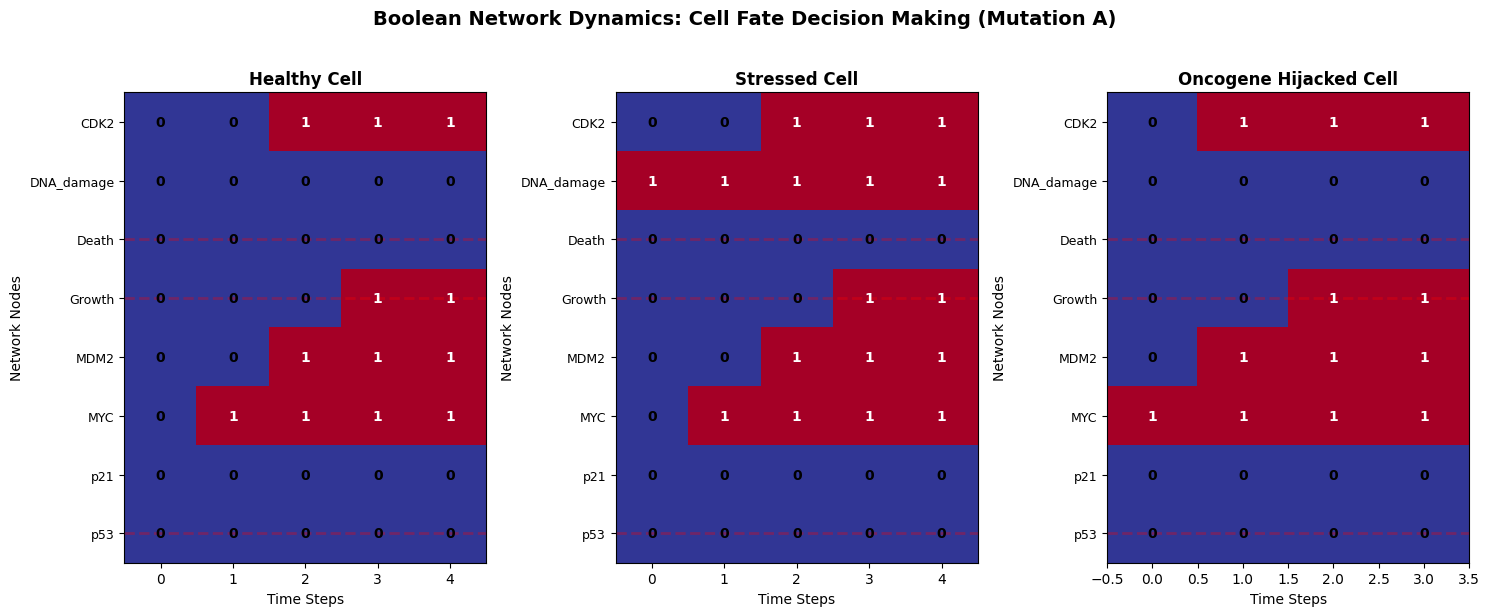

In [47]:
# Visualize results
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))

if n_scenarios == 1:
    axes = [axes]

for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation

    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making (Mutation A)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Conclusion for mutation A: 

# Attractor Analysis
We start with the attractor analysis for mutation A

In [50]:
# Find the attractor states
import itertools

attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)

print(f"Testing all {2**n_nodes} possible initial states...")

# TODO: Generate all possible initial states
# Hint: Use itertools.product([0, 1], repeat=n_nodes)
all_states = list(itertools.product([0, 1], repeat=n_nodes))

for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)

  # TODO: Simulate the network
  trajectory = network.simulate(steps=8)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

print(f"\nFound {len(attractors)} attractors:")
for a in attractors:
    print(dict(zip(node_names, a)))

Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reac


FOUND 2 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy proliferating cell (normal growth, no stress)

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Uncontrolled growth despite DNA damage (possible tumor-like state)


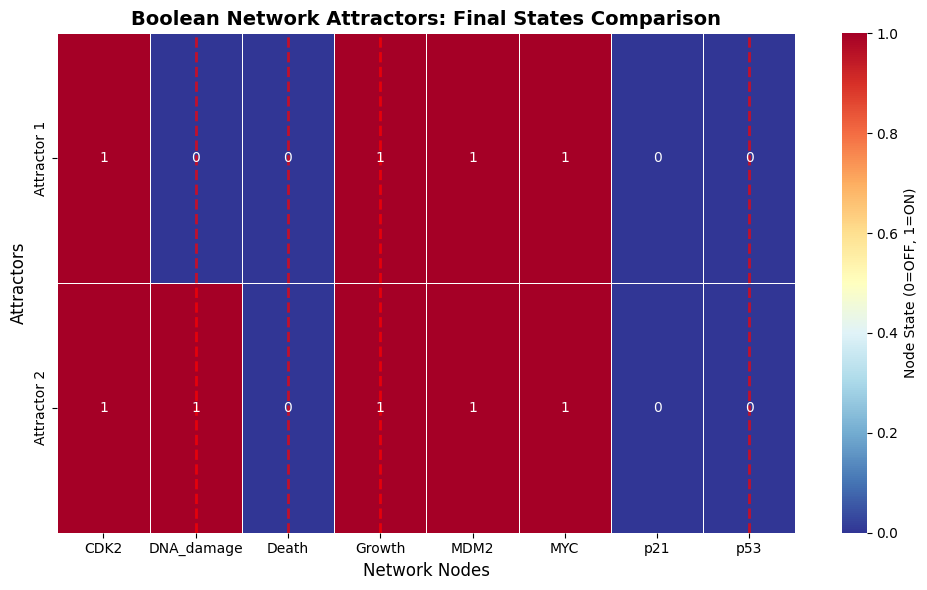

In [63]:
print(f"\nFOUND {len(attractors)} ATTRACTORS:")

for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")

        # Create state dictionary for easy access
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        # Analyze the biological meaning
        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1


        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        # TODO: Interpret the meaning
        if growth_active and not death_active and not dna_damage_active:
            interpretation = "Healthy proliferating cell (normal growth, no stress)"
        elif death_active and not growth_active:
            interpretation = "Cell death/apoptosis state (growth halted, death active)"
        elif growth_active and not death_active and dna_damage_active and not p53_active:
            interpretation = "Uncontrolled growth despite DNA damage (possible tumor-like state)"
        elif p53_active and dna_damage_active and not growth_active:
            interpretation = "DNA damage response triggered (p53 active, growth arrested)"
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")


# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

In [51]:
# Track which initial states lead to which attractors
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    # Set network state
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
    network.set_state(**state_dict)

    # Simulate
    trajectory = network.simulate(steps=max_steps, record_history=True)

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break


Analyzing 256 initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady 


Basin Sizes:
 Attractor 1: 128 states ( 50.0%) → Cancer-like (uncontrolled growth)
 Attractor 2: 128 states ( 50.0%) → Cancer-like (uncontrolled growth)


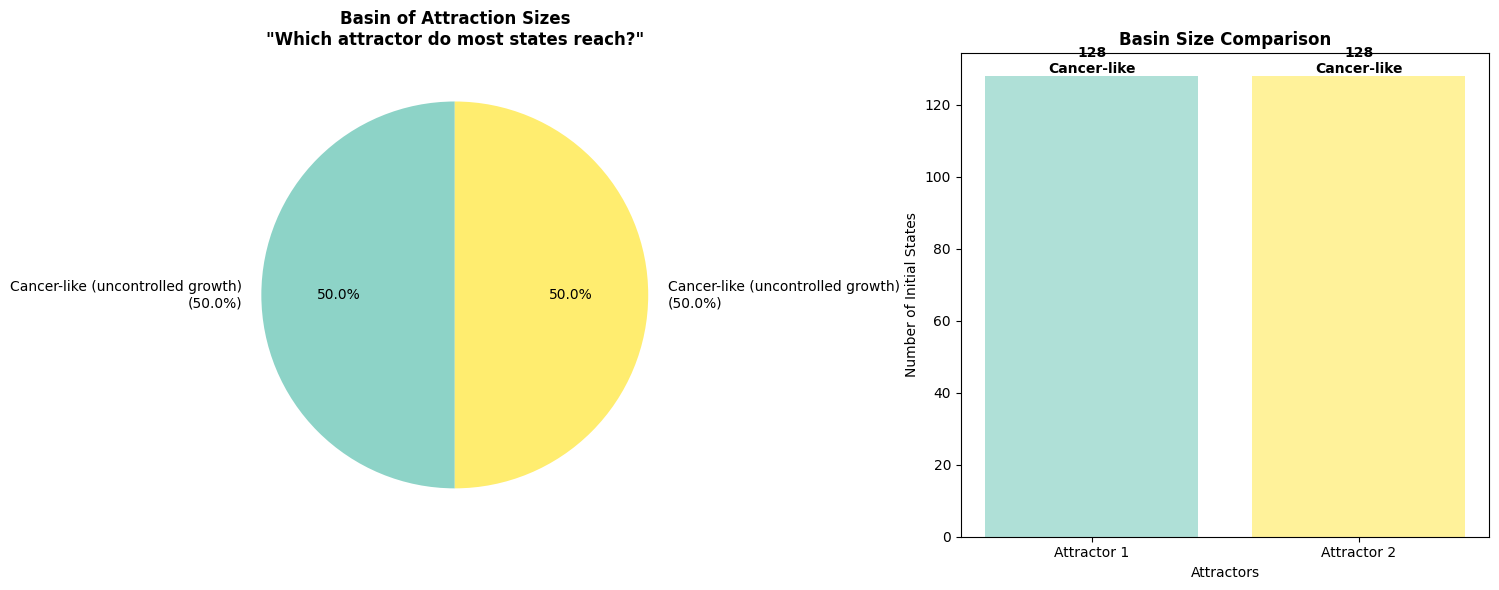

In [52]:
# Display basin sizes
print(f"\nBasin Sizes:")
total_states = len(all_states)

# Store results for plotting
basin_sizes = []
basin_labels = []

for att_idx, attractor in enumerate(attractors):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    
    # Interpret attractor biologically
    state_dict = dict(zip(node_names, attractor))
    growth_active = state_dict['Growth'] == 1
    death_active = state_dict['Death'] == 1
    p53_active = state_dict['p53'] == 1
    dna_damage_active = state_dict['DNA_damage'] == 1

    if growth_active and not death_active:
        interpretation = "Cancer-like (uncontrolled growth)"
    elif death_active and not growth_active:
        interpretation = "Apoptosis"
    elif not growth_active and not death_active:
        interpretation = "Quiescent / Arrest"
    else:
        interpretation = "Other / Mixed"

    print(f" Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%) → {interpretation}")

    basin_sizes.append(basin_size)
    basin_labels.append(f"{interpretation}\n({percentage:.1f}%)")

# --- Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))
wedges, texts, autotexts = ax1.pie(basin_sizes,
                                   labels=basin_labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90)

ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
              fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size, label in zip(bars, basin_sizes, basin_labels):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}\n{label.split()[0]}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
